# SWE pre-processing
This Notebook reads SWE station observations and precipitation station data (SCDNA, 1979-2018 Version 1.1; the complete data is available on Zenodo [here](https://zenodo.org/record/3953310#.YXnGQS1b1mA)) for a test river basin. It fills the gaps in the SWE station observations that are within the river basin, using quantile mapping with neighbouring SWE and precipitation station data.

Decisions:
- We only use SWE and precipitation station data within the test river basin, and do not apply any buffer around the basin. A distance-decay plot could be used to check the optimal buffer size.
- The water year definition is October 1st to September 30th of the next year. See user-specified variables below.
- The minimum correlation allowed to select an optimal donor station is set to 0.6 at the moment (no negative correlations selected). See user-specified variables below.
- The minimum number of overlapping observations required to calculate the correlation between two stations is set to 3 at the moment. See user-specified variables below.
- The minimum number of observations required to calculate a station's cdf is set to 10 at the moment. See user-specified variables below.
- We use a time window of +/- 7 days on either side of the infilling date for gap filling calculations. See user-specified variables below.
- The minimum number of observations required to calculate the KGE'' is set to 3 at the moment. See user-specified variables below.
- We perform a linear interpolation of the daily discharge data before calculating volumes, to fill in small data gap of maximum 15 days. See user-specified variables below.
- We evaluate the artificial gap filling quality based on the RMSE and the KGE'' decomposition.

The "Variables" section below is the only section a user will need to modify for testing different options for most of these decisions.

Notes:
- We do not look at data stationarity.

## Modules, settings & functions

In [1]:
# Import required modules
import datetime
from datetime import timedelta
import geopandas as gpd
import logging
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pprint import pprint
from shapely.geometry import Point
import sys
import warnings
import xarray as xr

In [2]:
# Add scripts to the system path
sys.path.append('../scripts')

# Set up logging, configured for this workflow (see utilities.py)
from utilities import setup_logging, read_settings
setup_logging()

# Set up logging for this notebook
logger = logging.getLogger()

# Suppress misc. comments from being added to the log file
logging.getLogger('matplotlib.font_manager').disabled = True
logging.getLogger('matplotlib.pyplot').disabled = True

# Get the logger for fiona._env and suppress everything below CRITICAL level
fiona_env_logger = logging.getLogger('fiona._env')
fiona_env_logger.setLevel(logging.CRITICAL)

%load_ext autoreload
%autoreload 2

2025-01-14 16:21:51,932 - root - INFO - Logging setup complete. Log file: C:\Users\lauri\PycharmProjects\FROSTBYTE_PREVAH\logs\data_driven_forecasting_20250114_162151.log


In [3]:
# Save Notebook name to the log file
logger.debug(f'Notebook: 3_SWEPreprocessing')

In [4]:
# Read settings file
settings = read_settings('../settings/config_test_case.yaml', log_settings=True)
pprint(settings)

2025-01-14 16:21:52,364 - root - INFO - Settings logged from ../settings/config_test_case.yaml


{'SWE_obs_path': '../PREVAH/input_data/SWE_prevah.nc',
 'basins_dem_path': '../PREVAH/input_data/MERIT_Hydro_dem_',
 'basins_shp_path': '../PREVAH/input_data/ebene_40km_with_ids.shp',
 'domain': 'V1021',
 'output_data_path': '../PREVAH/output_data/',
 'plots_path': '../PREVAH/output_plots/',
 'precip_obs_path': '../PREVAH/input_data/P_prevah.nc',
 'streamflow_obs_path': '../PREVAH/input_data/Q_prevah.nc'}


In [5]:
# Import required functions
from functions import extract_stations_in_basin, stations_basin_map, data_availability_monthly_plots_1, data_availability_monthly_plots_2, qm_gap_filling, artificial_gap_filling, plots_artificial_gap_evaluation

## Variables

In [6]:
# Set user-specified variables
test_basin_id = settings['domain'] # Can override this with testbasin_id = <string of the testbasin id>, make sure that this id is in the input data files
flag_buffer_default, buffer_km_default = 0, 0 # buffer flag (0: no buffer around test basin, 1: buffer of value buffer_default around test basin) and buffer default value in km to be applied if flag = 1
month_start_water_year_default, day_start_water_year_default = 10, 1  # water year start
month_end_water_year_default, day_end_water_year_default = 9, 30  # water year end
min_obs_corr_default = 3 # the minimum number of overlapping observations required to calculate the correlation between 2 stations
min_obs_cdf_default = 10 # the minimum number of observations required to calculate a station's cdf
min_corr_default = 0.6 # the minimum correlation value required for donor stations to be selected
window_days_default = 7 # the number of days used on either side of the infilling date for gap filling calculations
min_obs_KGE_default = 3 # the minimum number of observations required to calculate the KGE''
max_gap_days_default = 15  # max. number of days for gaps allowed in the daily SWE data for the linear interpolation
iterations_default = 1 # the number of times we repeat the artificial gap filling (this should = 1 if artificial_gap_perc_default = 100, if artificial_gap_perc_default < 100, it can be set to > 1)
artificial_gap_perc_default = 100 # the percentage of observations to remove during the artificial gap filling for each station & month's first day

In [7]:
# Save the user-specified variables to the log file
logger.debug(f'test basin ID: {test_basin_id}')
logger.debug(f'buffer around basin for SWE and precip. stations selection (km): {buffer_km_default}')
logger.debug(f'water year start (month/day): {month_start_water_year_default}/{day_start_water_year_default}')
logger.debug(f'water year end (month/day): {month_end_water_year_default}/{day_end_water_year_default}')
logger.debug(f'min. number of obs. for correlation calculation: {min_obs_corr_default}')
logger.debug(f'min. number of obs. for building CDF: {min_obs_cdf_default}')
logger.debug(f'min. Pearson correlation for selection of donor stations: {min_corr_default}')
logger.debug(f'window length for infilling (days on either side of date): {window_days_default}')
logger.debug(f'min. number of obs. for KGE" calculation: {min_obs_KGE_default}')
logger.debug(f'linear interpolation maximum gap (days): {max_gap_days_default}')
logger.debug(f'percentage of observations to remove for artificial gap filling: {artificial_gap_perc_default}')

## Read data

In [8]:
# Read SWE station observations NetCDF
SWE_stations_ds = xr.open_dataset(settings['SWE_obs_path'])
display(SWE_stations_ds)
SWE_stations_ds = SWE_stations_ds.assign_coords({'lon':SWE_stations_ds.lon, 'lat':SWE_stations_ds.lat, 'Station_ID':SWE_stations_ds.Station_ID}).swe
#SWE_stations_ds = SWE_stations_ds.assign_coords({'lon':SWE_stations_ds.lon, 'lat':SWE_stations_ds.lat, 'station_name':SWE_stations_ds.station_name}).snw
SWE_stations_ds = SWE_stations_ds.to_dataset()

display(SWE_stations_ds)

<xarray.Dataset>
Dimensions:     (Station_ID: 1170, time: 15340)
Coordinates:
  * time        (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2022-12-31
  * Station_ID  (Station_ID) object 'V1' 'V2' 'V3' ... 'V1168' 'V1169' 'V1170'
    lon         (Station_ID) float64 ...
    lat         (Station_ID) float64 ...
Data variables:
    swe         (time, Station_ID) float64 ...

<xarray.Dataset>
Dimensions:     (Station_ID: 1170, time: 15340)
Coordinates:
  * time        (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2022-12-31
  * Station_ID  (Station_ID) object 'V1' 'V2' 'V3' ... 'V1168' 'V1169' 'V1170'
    lon         (Station_ID) float64 2.511e+06 2.803e+06 ... 2.537e+06 2.496e+06
    lat         (Station_ID) float64 1.151e+06 1.182e+06 ... 1.179e+06 1.143e+06
Data variables:
    swe         (time, Station_ID) float64 ...

In [9]:
#SWE_stations_ds = SWE_stations_ds.rename({"Station_ID": "station_name"})
print(SWE_stations_ds)

<xarray.Dataset>
Dimensions:     (Station_ID: 1170, time: 15340)
Coordinates:
  * time        (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2022-12-31
  * Station_ID  (Station_ID) object 'V1' 'V2' 'V3' ... 'V1168' 'V1169' 'V1170'
    lon         (Station_ID) float64 2.511e+06 2.803e+06 ... 2.537e+06 2.496e+06
    lat         (Station_ID) float64 1.151e+06 1.182e+06 ... 1.179e+06 1.143e+06
Data variables:
    swe         (time, Station_ID) float64 ...


In [10]:
#Anpassung 10.10.24 SWE_Camels_testbasin_id speichern --> PCA funktioniert nicht mit nur einer Datenreihe
# --> entkomentieren zur visualisierung das es mit camels nicht funktioniert --> gleichzeitig müsste im 4_ die zelle mit diesem datum entkomentiert werden
#SWE_testbasin_ds = SWE_stations_ds.where(SWE_stations_ds.station_id==test_basin_id, drop=True)
#SWE_testbasin_ds = SWE_testbasin_ds.set_index({"station_id":"station_id"})
#output_filename = f"SWE_Camels_{test_basin_id}.nc"
#SWE_testbasin_ds.to_netcdf(f"{settings['output_data_path']}{output_filename}")

In [11]:
# Convert SWE stations DataArray to GeoDataFrame for further analysis
"""
data = {'station_id': SWE_stations_ds.station_id.data, 
        'lon': SWE_stations_ds.lon.data, 
        'lat': SWE_stations_ds.lat.data} 
df = pd.DataFrame(data)
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
crs = "EPSG:4326"
SWE_stations_gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

display(SWE_stations_gdf)
"""

print(SWE_stations_ds.Station_ID.data.shape)
print(SWE_stations_ds.lon.data.shape)
print(SWE_stations_ds.lat.data.shape)
data = {'station_id': SWE_stations_ds.Station_ID.data, 
        'lon': SWE_stations_ds.lon.data, 
        'lat': SWE_stations_ds.lat.data} 
df = pd.DataFrame(data)
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
crs = "EPSG:2056"
SWE_stations_gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

#SWE_stations_gdf_lv95 = SWE_stations_gdf.to_crs("EPSG:2056")

display(SWE_stations_gdf)



(1170,)
(1170,)
(1170,)


,station_id,lon,lat,geometry
0,V1,2.511065e+06,1.151361e+06,POINT (2511065.499 1151360.796)
1,V2,2.803190e+06,1.181862e+06,POINT (2803190.227 1181862.435)
2,V3,2.632283e+06,1.170901e+06,POINT (2632282.948 1170900.987)
3,V4,2.576863e+06,1.216274e+06,POINT (2576863.109 1216274.312)
4,V5,2.747332e+06,1.165284e+06,POINT (2747332.183 1165284.134)
...,...,...,...,...
1165,V1166,2.615419e+06,1.135879e+06,POINT (2615419.034 1135879.414)
1166,V1167,2.659035e+06,1.146034e+06,POINT (2659034.846 1146033.614)
1167,V1168,2.715826e+06,1.081363e+06,POINT (2715825.633 1081363.394)
1168,V1169,2.536821e+06,1.179322e+06,POINT (2536821.278 1179321.880)


In [12]:
#LNU koordinaten in LV95 umwandeln
# Überprüfen der Dimensionen der Datenarrays
print(SWE_stations_ds.Station_ID.data.shape)
print(SWE_stations_ds.lon.data.shape)
print(SWE_stations_ds.lat.data.shape)

# Erstellen des DataFrames
data = {
    'station_id': SWE_stations_ds.Station_ID.data,
    'lon': SWE_stations_ds.lon.data,
    'lat': SWE_stations_ds.lat.data
}
df = pd.DataFrame(data)

# Erstellen der Geometrien
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
"""
# Definieren des ursprünglichen Koordinatensystems (EPSG:21781)
crs = "EPSG:21781"
SWE_stations_gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

# Anzeigen des ursprünglichen GeoDataFrame
print("Vor der Umwandlung (EPSG:21781):")
display(SWE_stations_gdf)

# Umwandeln in das neue Koordinatensystem (EPSG:2056)
SWE_stations_gdf_lv95 = SWE_stations_gdf.to_crs("EPSG:2056")

# Anzeigen des umgewandelten GeoDataFrame
print("Nach der Umwandlung (EPSG:2056):")
display(SWE_stations_gdf_lv95)

# Überprüfung der Koordinaten nach Umwandlung
print("Umgewandelte Koordinaten (EPSG:2056):")
"""
print(SWE_stations_gdf[['geometry']])
#SWE_stations_gdf = SWE_stations_gdf_lv95

(1170,)
(1170,)
(1170,)
                             geometry
0     POINT (2511065.499 1151360.796)
1     POINT (2803190.227 1181862.435)
2     POINT (2632282.948 1170900.987)
3     POINT (2576863.109 1216274.312)
4     POINT (2747332.183 1165284.134)
...                               ...
1165  POINT (2615419.034 1135879.414)
1166  POINT (2659034.846 1146033.614)
1167  POINT (2715825.633 1081363.394)
1168  POINT (2536821.278 1179321.880)
1169  POINT (2495892.754 1142903.855)

[1170 rows x 1 columns]


<IPython.core.display.Javascript object>


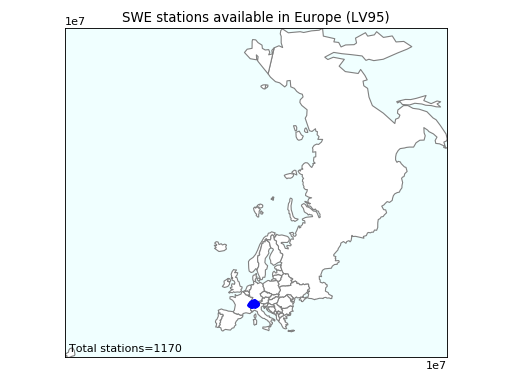

'\nworld_gdf = gpd.read_file(gpd.datasets.get_path(\'naturalearth_lowres\'))\nNA_albers_gdf = world_gdf[world_gdf[\'continent\']==\'North America\'].to_crs("ESRI:102008")\nax = NA_albers_gdf.plot(linewidth=1, edgecolor=\'grey\', color=\'white\')\nSWE_stations_albers_gdf = SWE_stations_gdf.copy().to_crs("ESRI:102008")\nSWE_stations_albers_gdf.plot(ax=ax, color=\'b\', alpha=.5, markersize=5)             \nminx, miny, maxx, maxy = np.nanmin(NA_albers_gdf.geometry.bounds.minx),np.nanmin(NA_albers_gdf.geometry.bounds.miny),np.nanmax(NA_albers_gdf.geometry.bounds.maxx),np.nanmax(NA_albers_gdf.geometry.bounds.maxy)\nax.set_xlim(minx, maxx)\nax.set_ylim(miny, maxy)\nax.margins(0)\nax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)\nax.set_facecolor(\'azure\')\nplt.title(\'SWE stations available\')\nplt.text(.01, .01,\'Total stations=\'+str(len(SWE_stations_albers_gdf.index)), ha=\'left\', va=\'bottom\', transform=ax.transAxes)\nplt.tight_layout();\n'

In [13]:
# Plot SWE stations available

# Laden der Weltkarte
world_gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Filter für Europa anwenden
EU_albers_gdf = world_gdf[world_gdf['continent'] == 'Europe']

# Umwandeln ins LV95-Koordinatensystem (EPSG:2056)
EU_LV95_gdf = EU_albers_gdf.to_crs(epsg=2056)

# Plot der Europa-Karte im Schweizer Koordinatensystem LV95
ax = EU_LV95_gdf.plot(linewidth=1, edgecolor='grey', color='white')

# Annahme: SWE_stations_gdf ist bereits geladen
# Umprojektion der SWE-Stationen in das LV95-Koordinatensystem
SWE_stations_LV95_gdf = SWE_stations_gdf.copy().to_crs(epsg=2056)

# Plot der SWE-Stationen auf der Europa-Karte
SWE_stations_LV95_gdf.plot(ax=ax, color='b', alpha=.5, markersize=5)

# Kartengrenzen setzen, basierend auf den minimalen und maximalen Koordinaten in Europa
minx, miny, maxx, maxy = np.nanmin(EU_LV95_gdf.geometry.bounds.minx), np.nanmin(EU_LV95_gdf.geometry.bounds.miny), np.nanmax(EU_LV95_gdf.geometry.bounds.maxx), np.nanmax(EU_LV95_gdf.geometry.bounds.maxy)
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot-Details anpassen
ax.margins(0)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
ax.set_facecolor('azure')
plt.title('SWE stations available in Europe (LV95)')
plt.text(.01, .01, 'Total stations=' + str(len(SWE_stations_LV95_gdf.index)), ha='left', va='bottom', transform=ax.transAxes)
plt.tight_layout()

plt.show()



"""
world_gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
NA_albers_gdf = world_gdf[world_gdf['continent']=='North America'].to_crs("ESRI:102008")
ax = NA_albers_gdf.plot(linewidth=1, edgecolor='grey', color='white')
SWE_stations_albers_gdf = SWE_stations_gdf.copy().to_crs("ESRI:102008")
SWE_stations_albers_gdf.plot(ax=ax, color='b', alpha=.5, markersize=5)             
minx, miny, maxx, maxy = np.nanmin(NA_albers_gdf.geometry.bounds.minx),np.nanmin(NA_albers_gdf.geometry.bounds.miny),np.nanmax(NA_albers_gdf.geometry.bounds.maxx),np.nanmax(NA_albers_gdf.geometry.bounds.maxy)
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.margins(0)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
ax.set_facecolor('azure')
plt.title('SWE stations available')
plt.text(.01, .01,'Total stations='+str(len(SWE_stations_albers_gdf.index)), ha='left', va='bottom', transform=ax.transAxes)
plt.tight_layout();
"""

You can zoom into the map with the rectangle icon ("zoom to rectangle") showing below the figure. Here, you see that the sample data contains SWE station observations for an area around two river basins, one in the USA and one in Canada, for which we also have all the data needed to run this workflow (e.g., discharge observations).

In [14]:
# Read meteorological station observations NetCDF
met_stations_ds = xr.open_dataset(settings['precip_obs_path'])

display(met_stations_ds)
print(met_stations_ds.LLE)

<xarray.Dataset>
Dimensions:        (ID: 1170, lle: 3, nday: 15340, station: 1170)
Coordinates:
  * nday           (nday) datetime64[ns] 1981-01-01 1981-01-02 ... 2022-12-31
  * ID             (ID) object 'V1' 'V2' 'V3' 'V4' ... 'V1168' 'V1169' 'V1170'
  * lle            (lle) object 'lon' 'lat' 'elev'
Dimensions without coordinates: station
Data variables:
    precipitation  (nday, ID) float64 ...
    LLE            (station, lle) float64 ...

<xarray.DataArray 'LLE' (station: 1170, lle: 3)>
array([[2511065.499034, 1151360.796234,            nan],
       [2803190.226554, 1181862.435466,            nan],
       [2632282.947776, 1170900.986601,            nan],
       ...,
       [2715825.632639, 1081363.393783,            nan],
       [2536821.27808 , 1179321.879591,            nan],
       [2495892.753555, 1142903.854761,            nan]])
Coordinates:
  * lle      (lle) object 'lon' 'lat' 'elev'
Dimensions without coordinates: station


In [15]:
# LNU --> nstn hinzufügen
#Erstelle eine neue durchnummerierte Variable für 'nstn'
nstn_values = np.arange(met_stations_ds.dims['station'])  # Erzeugt eine Liste [0, 1, 2, ..., N-1], wobei N die Anzahl der Stationen ist

# Füge diese Variable als 'nstn' hinzu
met_stations_ds['nstn'] = xr.DataArray(nstn_values, dims=['station'])

display(met_stations_ds)

<xarray.Dataset>
Dimensions:        (ID: 1170, lle: 3, nday: 15340, station: 1170)
Coordinates:
  * nday           (nday) datetime64[ns] 1981-01-01 1981-01-02 ... 2022-12-31
  * ID             (ID) object 'V1' 'V2' 'V3' 'V4' ... 'V1168' 'V1169' 'V1170'
  * lle            (lle) object 'lon' 'lat' 'elev'
Dimensions without coordinates: station
Data variables:
    precipitation  (nday, ID) float64 ...
    LLE            (station, lle) float64 2.511e+06 1.151e+06 ... 1.143e+06 nan
    nstn           (station) int32 0 1 2 3 4 5 ... 1164 1165 1166 1167 1168 1169

In [16]:
# LNU ich versuche "Convert meteorological stations DataSet to GeoDataFrame for further analysis"
lon = met_stations_ds.LLE[:, 0].values  # Extract longitude
lat = met_stations_ds.LLE[:, 1].values  # Extract latitude
elev = met_stations_ds.LLE[:, 2].values  # Extract elevation
station = met_stations_ds.station[:].values

# Step 2: Create a DataFrame
data = {
    'lon': lon, 
    'lat': lat,
    'elev': elev,
    'station': station
}
df = pd.DataFrame(data)

# Step 3: Create geometry for GeoDataFrame
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]

# Step 4: Create the GeoDataFrame (ensure correct CRS)
# If your coordinates are in EPSG:21781, set crs accordingly
met_stations_gdf = gpd.GeoDataFrame(df, crs="EPSG:2056", geometry=geometry)

# Display the GeoDataFrame
print(met_stations_gdf)

               lon           lat  elev  station  \
0     2.511065e+06  1.151361e+06   NaN        0   
1     2.803190e+06  1.181862e+06   NaN        1   
2     2.632283e+06  1.170901e+06   NaN        2   
3     2.576863e+06  1.216274e+06   NaN        3   
4     2.747332e+06  1.165284e+06   NaN        4   
...            ...           ...   ...      ...   
1165  2.615419e+06  1.135879e+06   NaN     1165   
1166  2.659035e+06  1.146034e+06   NaN     1166   
1167  2.715826e+06  1.081363e+06   NaN     1167   
1168  2.536821e+06  1.179322e+06   NaN     1168   
1169  2.495893e+06  1.142904e+06   NaN     1169   

                             geometry  
0     POINT (2511065.499 1151360.796)  
1     POINT (2803190.227 1181862.435)  
2     POINT (2632282.948 1170900.987)  
3     POINT (2576863.109 1216274.312)  
4     POINT (2747332.183 1165284.134)  
...                               ...  
1165  POINT (2615419.034 1135879.414)  
1166  POINT (2659034.846 1146033.614)  
1167  POINT (2715825.633 10

In [17]:
# Convert meteorological stations DataSet to GeoDataFrame for further analysis
"""
data = {'lon': met_stations_ds.LLE.data[1], 
        'lat': met_stations_ds.LLE.data[0],
        'elev': met_stations_ds.LLE.data[2]} 
df = pd.DataFrame(data)
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
met_stations_gdf = gpd.GeoDataFrame(df, crs="EPSG:4326", geometry=geometry)#EPSG:21781

display(met_stations_gdf)
"""



'\ndata = {\'lon\': met_stations_ds.LLE.data[1], \n        \'lat\': met_stations_ds.LLE.data[0],\n        \'elev\': met_stations_ds.LLE.data[2]} \ndf = pd.DataFrame(data)\ngeometry = [Point(xy) for xy in zip(df[\'lon\'], df[\'lat\'])]\nmet_stations_gdf = gpd.GeoDataFrame(df, crs="EPSG:4326", geometry=geometry)#EPSG:21781\n\ndisplay(met_stations_gdf)\n'

<IPython.core.display.Javascript object>


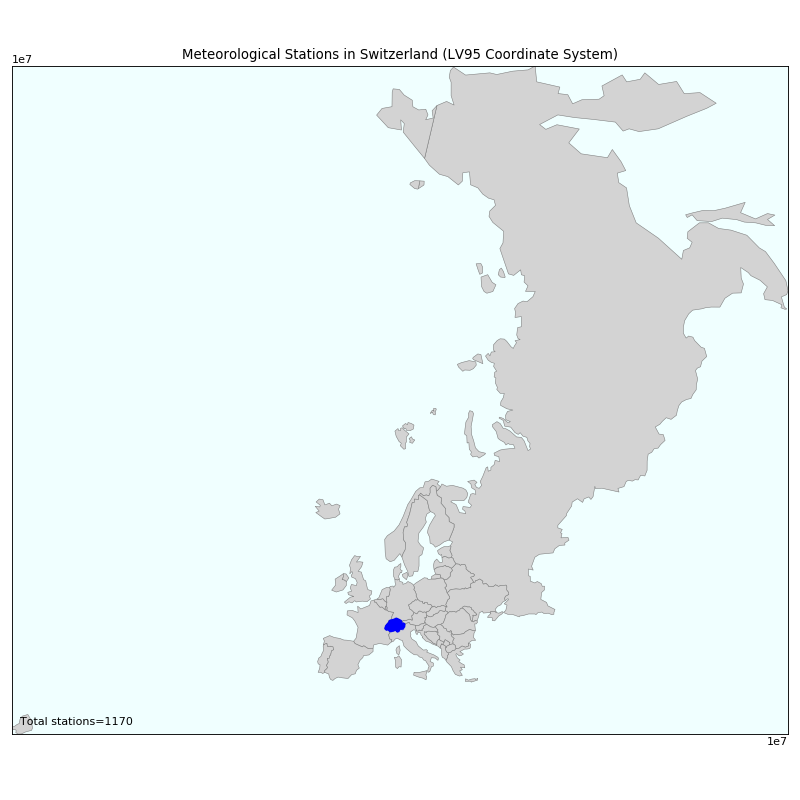

In [18]:
# Plot meteorological stations available
"""
NA_gdf = world_gdf[world_gdf['continent']=='North America']
ax = NA_gdf.plot(linewidth=1, edgecolor='grey', color='white')
plt.scatter(met_stations_gdf.lon, met_stations_gdf.lat, color='b', alpha=.5, s=5)
minx, miny, maxx, maxy = np.nanmin(NA_gdf.geometry.bounds.minx),np.nanmin(NA_gdf.geometry.bounds.miny),np.nanmax(NA_gdf.geometry.bounds.maxx),np.nanmax(NA_gdf.geometry.bounds.maxy)
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.margins(0)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
ax.set_facecolor('azure')
plt.title('Meteorological stations available')
plt.text(.01, .01,'Total stations='+str(len(met_stations_gdf.index)), ha='left', va='bottom', transform=ax.transAxes)
plt.tight_layout();
"""

# Lade die Weltkarte
world_gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Transformiere die Weltkarte in das LV95-Koordinatensystem (EPSG:21781)
# Bei einer Weltkarte kann es sinnvoller sein, nur die Schweiz oder Europa zu betrachten.
# Du kannst auch nur die Länder der EU oder angrenzende Länder wählen.
swiss_gdf = world_gdf[world_gdf['name'] == 'Switzerland'].to_crs(epsg=2056)

# Erstelle eine größere Europakarte, die in LV95 transformiert ist, wenn gewünscht
# Hier werden die Umrisse der Länder verwendet, um die relevante Region anzuzeigen
europe_gdf = world_gdf[world_gdf['continent'] == 'Europe'].to_crs(epsg=2056)

# Erstelle einen Plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot der Europäischen Karte im LV95-Koordinatensystem
europe_gdf.plot(ax=ax, linewidth=0.5, edgecolor='grey', color='lightgrey')

# Überlagere die meteorologischen Stationsdaten
plt.scatter(met_stations_gdf.geometry.x, met_stations_gdf.geometry.y, color='b', alpha=0.5, s=5)

# Setze die Grenzen der Achsen
minx, miny, maxx, maxy = europe_gdf.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Weitere Einstellungen für die Darstellung
ax.margins(0)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
ax.set_facecolor('azure')

# Titel und Text auf der Karte
plt.title('Meteorological Stations in Switzerland (LV95 Coordinate System)')
plt.text(0.01, 0.01, f'Total stations={len(met_stations_gdf.index)}', ha='left', va='bottom', transform=ax.transAxes)

plt.tight_layout()
plt.show()



Same comments as for the SWE map above. Note that not all meteorological stations contained in this dataset have precipitation data. Some only have temperature for example. We will sort out the stations with precipitation later in this workflow.

## Extract SWE and precipitation stations in the basin

In [19]:
# Read test basin's shapefile
basins_gdf = gpd.read_file(settings['basins_shp_path'])
basins_gdf = basins_gdf.rename(columns={"ID": "Station_ID"})
basins_gdf = basins_gdf.rename(columns={"tezgnr40": "Station_Na"})
shp_testbasin_gdf = basins_gdf.loc[basins_gdf.Station_ID == test_basin_id]
#basins_gdf['gauge_id'] = basins_gdf['gauge_id'].astype(str)
#shp_testbasin_gdf = basins_gdf.loc[basins_gdf.gauge_id == test_basin_id]

print("basins_gdf:")
print(basins_gdf.dtypes)  # Zeigt die Datentypen des basins_gdf
print("Datentyp test_basin_id:")
print(type(test_basin_id))  # Zeigt den Datentyp von test_basin_id

display(shp_testbasin_gdf)

basins_gdf:
Station_Na       int64
Shape_Leng     float64
Shape_Area     float64
teilezgfla     float64
Station_ID      object
lon            float64
lat            float64
geometry      geometry
dtype: object
Datentyp test_basin_id:
<class 'str'>


,Station_Na,Shape_Leng,Shape_Area,teilezgfla,Station_ID,lon,lat,geometry
1020,108788,36360.730372,5.930330e+07,59.3,V1021,2.645581e+06,1.118160e+06,"POLYGON Z ((2642031.650 1123339.983 0.000, 264..."


CRS von shp_testbasin_gdf: epsg:2056
CRS von SWE_stations_gdf: EPSG:2056
CRS von met_stations_gdf: EPSG:2056


<IPython.core.display.Javascript object>


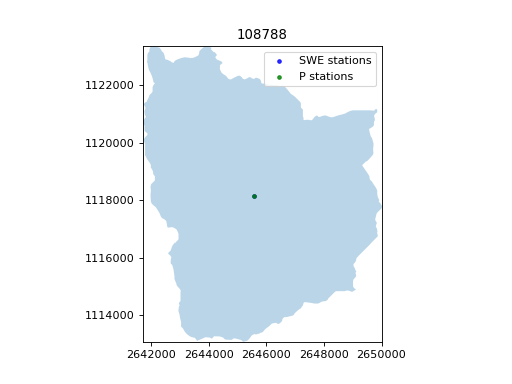

In [20]:
# Plot a map of the test basin and of the SWE and meteorological stations available
print("CRS von shp_testbasin_gdf:", shp_testbasin_gdf.crs)
print("CRS von SWE_stations_gdf:", SWE_stations_gdf.crs)
print("CRS von met_stations_gdf:", met_stations_gdf.crs)
fig = stations_basin_map(shp_testbasin_gdf, test_basin_id, SWE_stations_gdf, met_stations_gdf, flag=flag_buffer_default, buffer_km=buffer_km_default)

We will now extract the SWE and meteorological stations that fall within the basin only.

In [21]:
# Extract SWE stations within test basin (+ optional buffer) and save info to DataFrame
SWE_stations_in_basin = extract_stations_in_basin(SWE_stations_gdf, shp_testbasin_gdf, test_basin_id, buffer_km=buffer_km_default)[0]

display(SWE_stations_in_basin)

print('There are',str(len(SWE_stations_in_basin.index)),'SWE stations within the test basin.')

,station_id,lon,lat,geometry,basin
1020,V1021,2.645581e+06,1.118160e+06,POINT (2645581.240 1118160.066),V1021


There are 1 SWE stations within the test basin.


In [22]:
# Extract meteorological stations within test basin (+ optional buffer) and save info to DataFrame
met_stations_in_basin = extract_stations_in_basin(met_stations_gdf, shp_testbasin_gdf, test_basin_id, buffer_km=buffer_km_default)[0]

display(met_stations_in_basin)

print('There are',str(len(met_stations_in_basin.index)),'meteorological stations within the test basin.')

,lon,lat,elev,station,geometry,basin
1020,2.645581e+06,1.118160e+06,NaN,1020,POINT (2645581.240 1118160.066),V1021


There are 1 meteorological stations within the test basin.


<IPython.core.display.Javascript object>


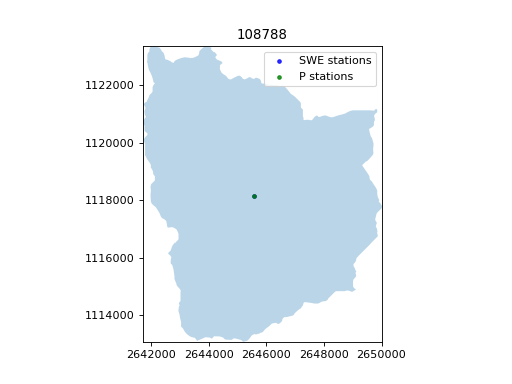

In [23]:
# Plot map of test basin (+ optional buffer) and the extracted stations
fig = stations_basin_map(shp_testbasin_gdf, test_basin_id, SWE_stations_in_basin, met_stations_in_basin, flag=flag_buffer_default, buffer_km=buffer_km_default)

We will now extract the SWE station observations in the test basin and make a few plots.

In [24]:
# Sub-select SWE station observations in test basin and convert to Pandas DataFrame
display(SWE_stations_ds)
SWE_testbasin_ds = SWE_stations_ds.sel(Station_ID = SWE_stations_in_basin["station_id"].values)
display(SWE_testbasin_ds)
# Convert test basin SWE data DataSet to Pandas DataFrame for further analysis
SWE_testbasin_df = SWE_testbasin_ds.to_dataframe().drop(columns=['lon','lat',]).unstack()['swe'].T
#SWE_testbasin_df = SWE_testbasin_ds.to_dataframe().drop(columns=['lon','lat','station_name']).unstack()['snw'].T
SWE_testbasin_df['date'] = SWE_testbasin_df.index.normalize()
SWE_testbasin_df = SWE_testbasin_df.set_index('date')

display(SWE_testbasin_df)

<xarray.Dataset>
Dimensions:     (Station_ID: 1170, time: 15340)
Coordinates:
  * time        (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2022-12-31
  * Station_ID  (Station_ID) object 'V1' 'V2' 'V3' ... 'V1168' 'V1169' 'V1170'
    lon         (Station_ID) float64 2.511e+06 2.803e+06 ... 2.537e+06 2.496e+06
    lat         (Station_ID) float64 1.151e+06 1.182e+06 ... 1.179e+06 1.143e+06
Data variables:
    swe         (time, Station_ID) float64 ...

<xarray.Dataset>
Dimensions:     (Station_ID: 1, time: 15340)
Coordinates:
  * time        (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2022-12-31
  * Station_ID  (Station_ID) object 'V1021'
    lon         (Station_ID) float64 2.646e+06
    lat         (Station_ID) float64 1.118e+06
Data variables:
    swe         (time, Station_ID) float64 ...

Station_ID,V1021
date,
1981-01-01,287.593
1981-01-02,294.066
1981-01-03,328.374
1981-01-04,340.770
1981-01-05,345.694
...,...
2022-12-27,103.472
2022-12-28,103.086
2022-12-29,103.224


<IPython.core.display.Javascript object>


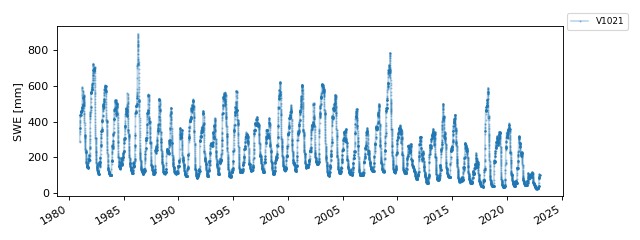

In [25]:
# Plot timeseries of SWE station observations in the test basin
fig = plt.figure(figsize=(8,3))

for s in SWE_testbasin_ds.Station_ID.values:
    SWE_testbasin_ds.swe.sel(Station_ID = s).plot(marker='o', alpha=.3, markersize=1, label=s)

plt.title('')
plt.ylabel('SWE [mm]')
plt.xlabel('')
plt.legend(bbox_to_anchor=(1,1.1), loc='upper left', fontsize=8)
plt.tight_layout();

In [26]:
# Save the figure
fig.savefig(settings['plots_path']+"SWE_timeseries_basin"+test_basin_id+".png", dpi=300)

In [27]:
# Close the figure - please run this as it will ensure that we're not overloading the memory unnecessarily
plt.close(fig)

<IPython.core.display.Javascript object>


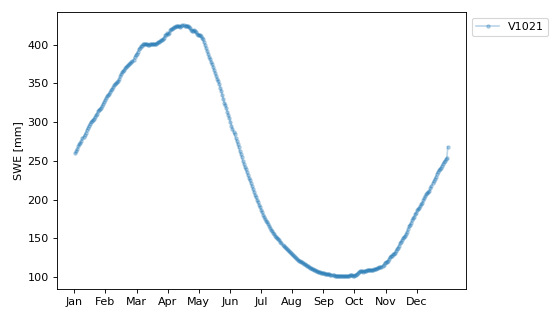

In [28]:
# Plot timeseries of test basin SWE observations climatological means
# We expect to see warnings as some days of the year only have missing values
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    
    fig = plt.figure(figsize=(7,4))

    for s in SWE_testbasin_ds.Station_ID.values:
        testbasin_SWE_climatology_means = SWE_testbasin_ds.swe.sel(Station_ID = s).groupby("time.dayofyear").mean(dim=xr.ALL_DIMS, skipna=True)
        testbasin_SWE_climatology_means.plot(marker='o', alpha=.3, markersize=3, label=s)

    plt.title('')
    plt.xticks(np.linspace(0,366,13)[:-1], ('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'))
    plt.xlabel('')
    plt.ylabel('SWE [mm]')
    plt.legend(bbox_to_anchor=(1,1), loc='upper left')
    plt.tight_layout();

We can see a striking difference in data availability between the more continuous automatic stations and the discontinuous manual surveys.

In [29]:
# Save the figure
fig.savefig(settings['plots_path']+"SWE_mean_climatology_basin"+test_basin_id+".png", dpi=300)

In [30]:
# Close the figure - please run this as it will ensure that we're not overloading the memory unnecessarily
plt.close(fig)

In [31]:
# Plot timeseries of the % of SWE stations with data in the test basin on the first day of each month
fig = data_availability_monthly_plots_1(SWE_stations_in_basin, SWE_testbasin_ds.swe, None, flag=0)

<IPython.core.display.Javascript object>

ValueError: dimensions or multi-index levels ['station_id'] do not exist

This shows timeseries of the percentage of all SWE stations in the test basin that actually have observations on the first day of each month (subplots). E.g., if all stations have data on the 1st of June 2000, the corresponding bar should show 100%. The reason we focus on the first of each month is because we will only be using these data as they correspond to the hindcast start dates (generated in the next Notebook). 

In [32]:
# Save the figure
fig.savefig(settings['plots_path']+"SWE_monthly_availability_1_basin"+test_basin_id+".png", dpi=300)

In [33]:
# Close the figure - please run this as it will ensure that we're not overloading the memory unnecessarily
plt.close(fig)

We understand that SWE measurements may not always be taken on the first of the month if they are manual measurements. In order to check how far from the first of each month measurements are taken within the test basin, we plot the SWE observations available around the first of day of each month.

<IPython.core.display.Javascript object>


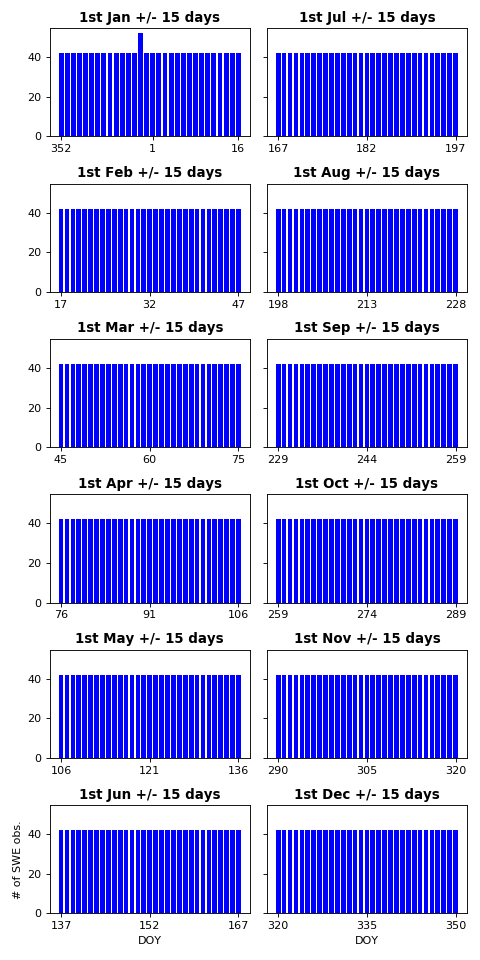

In [34]:
# Plot bar charts of the days with SWE observations around the first day of each month
fig = data_availability_monthly_plots_2(SWE_testbasin_df)

For the Bow at Banff, it looks like most of the manual SWE measurements are taken within a +/- 7 day window around the first day of each month during the snow accumulation period. These results could help us refine the time window used for the infilling (see user-specified variable at the top of this Notebook).

In [35]:
# Save the figure
fig.savefig(settings['plots_path']+"SWE_monthly_availability_2_basin"+test_basin_id+".png", dpi=300)

In [36]:
# Close the figure - please run this as it will ensure that we're not overloading the memory unnecessarily
plt.close(fig)

## Pre-process the SWE and precipitation basin datasets

### Precipitation pre-processing

We will first need to calculate water year station cumulative precipitation outputs to use as a proxy for SWE during the infilling step later on.

In [37]:

# Plot a bar chart of the number of times each donor station was used for infilling
count = []

for s in SWE_P_testbasin_df.columns.values:
    count_s = SWE_testbasin_gapfilled_ds.donor_stations.where(SWE_testbasin_gapfilled_ds.donor_stations==s).count().data
    count.append(count_s)

fig = plt.figure()
plt.bar(SWE_P_testbasin_df.columns.values, count, color='b')
plt.xticks(rotation=90)
plt.xlabel('Donor stations')
plt.ylabel('# times used for infilling')
plt.tight_layout();



NameError: name 'SWE_P_testbasin_df' is not defined

In [38]:

# Save the figure
fig.savefig(settings['plots_path']+"donor_stations_gapfilling_basin"+test_basin_id+".png", dpi=300)

In [39]:
# Close the figure - please run this as it will ensure that we're not overloading the memory unnecessarily
plt.close(fig)

In [40]:
# Station IDs in SWE_testbasin_ds konvertieren
SWE_testbasin_ds.swe = SWE_testbasin_ds.swe.assign_coords(station_id=SWE_testbasin_ds.swe.station_id.astype(str))

# Station IDs in SWE_testbasin_gapfilled_ds konvertieren
SWE_testbasin_gapfilled_ds.SWE = SWE_testbasin_gapfilled_ds.SWE.assign_coords(station_id=SWE_testbasin_gapfilled_ds.SWE.station_id.astype(str))

AttributeError: 'DataArray' object has no attribute 'station_id'

In [ ]:
# Save the figure
fig.savefig(settings['plots_path']+"SWE_monthly_availability_1_after_gap_filling_basin"+test_basin_id+".png", dpi=300)

In [41]:
# Close the figure - please run this as it will ensure that we're not overloading the memory unnecessarily
plt.close(fig)

### Artificial gap filling and evaluation
We remove data artificially from the SWE station observations to test the performance of the gap filling. Note that we only do this for the first of each month to limit the computation time.

In [42]:
# Plot artificial gap filling evaluation results
fig = plots_artificial_gap_evaluation(evaluation_artificial_gapfill_testbasin_dict)

NameError: name 'evaluation_artificial_gapfill_testbasin_dict' is not defined

The boxplots contain results for all SWE stations. For the Bow at Banff, we can see some low scores. This can sometimes happens for certain SWE stations with very few gaps to fill. If various donor stations are used to fill out these gaps, then there are some inconsistencies across infilling values and the overall correlation between the infilling values and the observations is poor.

## Save data
Save the output gap-filled SWE data so we can read them in other Notebooks.

In [43]:
# Save the data
# SWE_testbasin_gapfilled_ds.to_netcdf(settings['output_data_path']+"SWE_1979_2022_gapfilled_basin"+test_basin_id+".nc", format="NETCDF4")

In [44]:

try:
    # Prüfen, ob 'SWE_testbasin_gapfilled_ds' definiert ist
    SWE_testbasin_gapfilled_ds.to_netcdf(
        settings['output_data_path'] + "SWE_1979_2022_gapfilled_basin" + test_basin_id + ".nc",
        format="NETCDF4"
    )
except NameError:
    # Wenn 'SWE_testbasin_gapfilled_ds' nicht definiert ist
    SWE_testbasin_ds.to_netcdf(
        settings['output_data_path'] + "SWE_1979_2022_gapfilled_basin" + test_basin_id + ".nc",
        format="NETCDF4"
    )

In [45]:
display(SWE_testbasin_ds)

<xarray.Dataset>
Dimensions:     (Station_ID: 1, time: 15340)
Coordinates:
  * time        (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2022-12-31
  * Station_ID  (Station_ID) object 'V1021'
    lon         (Station_ID) float64 2.646e+06
    lat         (Station_ID) float64 1.118e+06
Data variables:
    swe         (time, Station_ID) float64 287.6 294.1 328.4 ... 104.6 102.9